Using device: cpu
Train: (5087, 3197) Test: (570, 3197)


c:\Users\amanb\anaconda3\envs\exoplanet\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/5, Loss: 7.0653
Epoch 2/5, Loss: 5.5308
Epoch 3/5, Loss: 5.4920
Epoch 4/5, Loss: 5.3267
Epoch 5/5, Loss: 5.2331

Classification Report:

              precision    recall  f1-score   support

   No Planet       0.99      1.00      1.00       565
      Planet       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



c:\Users\amanb\anaconda3\envs\exoplanet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\amanb\anaconda3\envs\exoplanet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\amanb\anaconda3\envs\exoplanet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

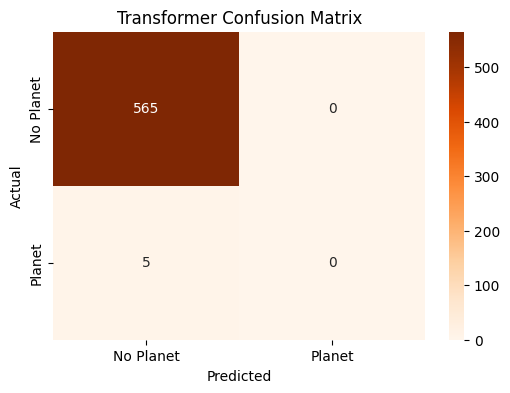

Model saved at ../results/transformer_model.pt


In [1]:
# ---------------------------
# Transformer Model for Exoplanet Detection
# ---------------------------

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Config
# ---------------------------
BATCH_SIZE = 32
EPOCHS = 5   # start small, increase later
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ---------------------------
# Load Data
# ---------------------------
train = pd.read_csv("../data/exoTrain.csv")
test = pd.read_csv("../data/exoTest.csv")

train['LABEL'] = train['LABEL'].apply(lambda x: 1 if x==2 else 0)
test['LABEL'] = test['LABEL'].apply(lambda x: 1 if x==2 else 0)

X_train = train.drop(columns=['LABEL']).values
y_train = train['LABEL'].values
X_test = test.drop(columns=['LABEL']).values
y_test = test['LABEL'].values

print("Train:", X_train.shape, "Test:", X_test.shape)

# ---------------------------
# Dataset + DataLoader
# ---------------------------
class ExoDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ExoDataset(X_train, y_train)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(ExoDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ---------------------------
# Transformer Model
# ---------------------------
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4, num_layers=2, num_classes=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: [batch, seq_len] -> [batch, seq_len, embed_dim]
        x = self.embedding(x)
        x = x.unsqueeze(1)  # [batch, 1, embed_dim]
        x = self.transformer(x)  # [batch, 1, embed_dim]
        x = x.mean(dim=1)  # global average pooling
        return self.fc(x)

model = TransformerClassifier(input_dim=X_train.shape[1]).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ---------------------------
# Training Loop
# ---------------------------
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

train_model()

# ---------------------------
# Evaluation
# ---------------------------
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Planet", "Planet"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["No Planet", "Planet"],
            yticklabels=["No Planet", "Planet"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Transformer Confusion Matrix")
plt.show()

# ---------------------------
# Save Model
# ---------------------------
torch.save(model.state_dict(), "../results/transformer_model.pt")
print("Model saved at ../results/transformer_model.pt")
